In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import time
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
EPSILON = 10e-10
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    raw_mel = librosa.feature.melspectrogram(X, sr=sample_rate).T
    mel = np.mean(raw_mel, axis=0)
    processed_mel = raw_mel + EPSILON
    logMel = np.mean(np.log(processed_mel),axis=0)
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,logMel, mel

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels, namePath = np.empty((0,296)), np.empty(0), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, logmel, mel = extract_feature(fn)
            ext_features = np.hstack([mfccs,logmel, mel])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[-1].split('-')[1])
            namePath = np.append(namePath, fn)
    return np.array(features), np.array(labels, dtype = np.int), np.array(namePath, dtype=np.string_)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def one_hot_decode(labels):
    n_labels, n_unique_labels = np.shape(labels)
    one_hot_decode = np.zeros((n_labels))
    for idx in range(n_labels):
        for l in range(n_unique_labels):
            if(labels[idx, l] == 1):
                one_hot_decode[idx] = l
                break;
    return one_hot_decode

In [3]:
x = extract_feature("../../data/UrbanSound8K/audio/fold1/7061-6-0-0.wav")
nfMfccs = np.shape(x[0])[0]
nfLogMel = np.shape(x[1])[0]
nfMel = np.shape(x[2])[0]

In [4]:
print "Number of features"
print "* Mfcc: {0}".format(nfMfccs)
print "* logMel {0}".format(nfLogMel)
print "* Mel {0}".format(nfMel)

Number of features
* Mfcc: 40
* logMel 128
* Mel 128


In [5]:
features = np.load("nn_shingled_features_fold_1.npy", allow_pickle=True)
labels = np.load("nn_labels_fold_1.npy", allow_pickle=True)
file_names = np.load("nn_file_names_fold_1.npy", allow_pickle=True)

In [6]:
one_hot_labels = one_hot_encode(labels)

In [18]:
np.shape(one_hot_labels)

(26036, 10)

-------------------------------------------------------------------------------------------------------------------------

### Training Neural Network with TensorFlow

In [7]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

--------------------------------------------------------------------------------------------------------------------------

In [10]:
# Initialize parameters
training_epochs = 20000 # number of iteration
n_samples, n_dim = np.shape(features) # number of features
n_classes = 10 # number of classes
n_hidden_units_one = 280  # number of units in hidden layer 1
n_hidden_units_two = 300 # number of units in hidden layer 2
sd = 1 / np.sqrt(n_dim) # std of initial weight and bias
learning_rate = 0.01 

In [11]:
# Randomly initialize params for each layers
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

# Hidden layer 1 params
W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

# Hidden layer 2 params
W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

# Softmax classification initialization
W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)


init = tf.global_variables_initializer()

In [12]:
# cost_function = 
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Train/Test split 70/30

In [13]:
from sklearn.cross_validation import train_test_split

In [14]:
features_and_filenames = np.concatenate((features[:,:n_dim], file_names[:,np.newaxis]), axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [24]:
train_x1, test_x1, train_y, test_y = train_test_split(features, one_hot_labels, test_size=0.3, random_state=5, stratify=labels)

In [25]:
train_x = train_x1
test_x = test_x1

In [26]:
labels

array([7, 7, 7, ..., 3, 3, 3])

In [27]:
np.shape(train_x)

(18225, 1680)

--- Start Training ---
Training.......
------ Elapsed time -------  Iter ---- Cost 
------    0.3827960 -------     0 ---- 2.3195612431 
------  243.8504970 -------  1000 ---- 1.2210352421 
------  487.2281709 -------  2000 ---- 0.7632224560 
------  742.1715550 -------  3000 ---- 0.4652549326 
------  991.3303599 -------  4000 ---- 0.3801034093 
------ 1236.4227009 -------  5000 ---- 0.2654215097 
------ 1490.9992599 -------  6000 ---- 0.2026490271 
------ 1745.6162410 -------  7000 ---- 0.1725730896 
------ 1995.8692510 -------  8000 ---- 0.1696489304 
------ 2247.4906979 -------  9000 ---- 0.1264232993 
------ 2493.1510339 ------- 10000 ---- 0.1174470931 
------ 2731.3025329 ------- 11000 ---- 0.2010377347 
------ 2974.7490740 ------- 12000 ---- 0.1245030239 
------ 3229.9193890 ------- 13000 ---- 0.0956732333 
------ 3477.9909499 ------- 14000 ---- 0.1010806486 
------ 3735.6282589 ------- 15000 ---- 0.0764675662 
------ 3988.9357131 ------- 16000 ---- 0.0945975929 
------ 4243.617

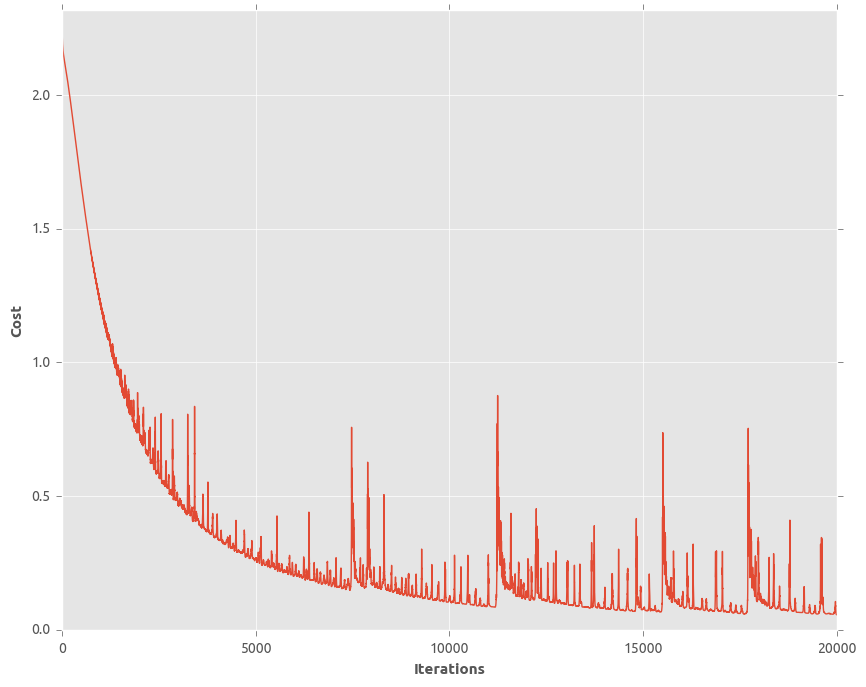

F-Score: 0.966073486109
Confusion Matrix
[[ 975    0    6    0    0    0    0    1    0    3]
 [   2  151    0    0    1    1    0    3    0    0]
 [  10    0  903   25    3    1    2    1    5   29]
 [   3    0   19  716    2    3    8    0    8    9]
 [   1    0    3    4  852    0    1    0    0    5]
 [   0    0    1    0    0  943    0    0    0    0]
 [   0    0    5   29    2    0  117    0    0    3]
 [   0    0    1    0    0    0    0 1112    0    1]
 [   0    0   11    5    0    4    0    0  825    6]
 [   2    0   14    7    2    1    2    4    6  952]]
---Training time: 4979.24680305 seconds ---
------------------------------------------


In [33]:
training_epochs = 20000 # number of iteration
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
print "--- Start Training ---"
print "Training......."
print "------ Elapsed time -------  Iter ---- Cost "
start_time = time.time()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
        if(epoch % 1000 == 0):
            print "------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), epoch, cost)
           
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()
    save_path = saver.save(sess,"model/nn_shingled_model_1.ckpt")
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)
print "---Training time: {0} seconds ---".format((time.time() - start_time))
print "------------------------------------------"

### Error Analysis

In [34]:
classID = {
    0: "AirCon",
    1: "Car horn",
    2: "Children playing",
    3: "Dog bark",
    4: "Drilling",
    5: "Engine idling",
    6: "Gun shot",
    7: "Jackhammer",
    8: "Siren",
    9: "Street music"
}

In [35]:
for ID, name in classID.items():
    x = y_pred[(y_true == ID)*(y_pred != ID)]  
    unique_class, unique_count = np.unique(x, return_counts=True)
    print "************************************************"
    print " Class {0} is mistaken with: ".format(name)
    for c, y in zip(unique_class, unique_count):        
        print "# {0}: {1} samples".format(classID[c], y)
print "************************************************"

************************************************
 Class AirCon is mistaken with: 
# Children playing: 6 samples
# Jackhammer: 1 samples
# Street music: 3 samples
************************************************
 Class Car horn is mistaken with: 
# AirCon: 2 samples
# Drilling: 1 samples
# Engine idling: 1 samples
# Jackhammer: 3 samples
************************************************
 Class Children playing is mistaken with: 
# AirCon: 10 samples
# Dog bark: 25 samples
# Drilling: 3 samples
# Engine idling: 1 samples
# Gun shot: 2 samples
# Jackhammer: 1 samples
# Siren: 5 samples
# Street music: 29 samples
************************************************
 Class Dog bark is mistaken with: 
# AirCon: 3 samples
# Children playing: 19 samples
# Drilling: 2 samples
# Engine idling: 3 samples
# Gun shot: 8 samples
# Siren: 8 samples
# Street music: 9 samples
************************************************
 Class Drilling is mistaken with: 
# AirCon: 1 samples
# Children playing: 3 samples

### Test

In [36]:
import pandas as pd

In [43]:
test_x = np.load("nn_shingled_features_test.npy", allow_pickle=True)
test_label = np.load("nn_labels_test.npy", allow_pickle=True)
test_file_names = np.load("nn_file_names_test.npy", allow_pickle=True)
test_y = one_hot_encode(test_label)
col10 = np.zeros(np.shape(test_label)[0])
test_y = np.concatenate((test_y, col10[:,np.newaxis]), axis=1)

In [44]:
np.shape(test_y)

(5419, 10)

In [49]:
with tf.Session() as sess:
    saver.restore(sess,"model/nn_shingled_model_1.ckpt")
    print "Test"
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)

Test
F-Score: 0.248016239159
Confusion Matrix
[[ 17   0   8  10   0   2   0  23  13 516]
 [ 98  57  71 197  44  18   0   8  36  46]
 [ 95   0 194  15   6  37   0  36 103 119]
 [ 56   3  49 263   0  64   7   3  99  80]
 [ 54   0  37   8  22  23   0 294  46 125]
 [ 37   0   5   0   0 174   0 139   2 250]
 [ 29   0  43  68  14  30   3 157  35 190]
 [ 72   0  45   3  30  23   0 239  22 176]
 [ 19  12  43   4   4  16   0  53 375 105]
 [  0   0   0   0   0   0   0   0   0   0]]


In [57]:
np.sum((y_pred == 1))

72

In [60]:
for ID, name in classID.items():
    x = y_pred[(y_true == ID)*(y_pred != ID)]
    correct = np.sum((y_pred == ID)*(y_true == ID))
    total = np.sum(y_true == ID)
    unique_class, unique_count = np.unique(x, return_counts=True)
    print "************************************************"
    print "Class {0}:".format(name)
    print " True/Total: {0}/{1}".format(correct,total)
    print " Class {0} is mistaken with: ".format(name)
    for c, y in zip(unique_class, unique_count):        
        print "# {0}: {1} samples".format(classID[c], y)
        
print "************************************************"

************************************************
Class AirCon:
 True/Total: 17/589
 Class AirCon is mistaken with: 
# Children playing: 8 samples
# Dog bark: 10 samples
# Engine idling: 2 samples
# Jackhammer: 23 samples
# Siren: 13 samples
# Street music: 516 samples
************************************************
Class Car horn:
 True/Total: 57/575
 Class Car horn is mistaken with: 
# AirCon: 98 samples
# Children playing: 71 samples
# Dog bark: 197 samples
# Drilling: 44 samples
# Engine idling: 18 samples
# Jackhammer: 8 samples
# Siren: 36 samples
# Street music: 46 samples
************************************************
Class Children playing:
 True/Total: 194/605
 Class Children playing is mistaken with: 
# AirCon: 95 samples
# Dog bark: 15 samples
# Drilling: 6 samples
# Engine idling: 37 samples
# Jackhammer: 36 samples
# Siren: 103 samples
# Street music: 119 samples
************************************************
Class Dog bark:
 True/Total: 263/624
 Class Dog bark is mis

### Fold 2

In [64]:
features_f2 = np.load("nn_shingled_features_fold_2.npy", allow_pickle=True)
labels_f2 = np.load("nn_labels_fold_2.npy", allow_pickle=True)
file_names_f2 = np.load("nn_file_names_fold_2.npy", allow_pickle=True)

In [65]:
test_x = features_f2
test_y = one_hot_encode(labels_f2)

In [66]:
with tf.Session() as sess:
    saver.restore(sess,"model/nn_shingled_model_1.ckpt")
    print "Test"
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)

Test
F-Score: 0.317801533814
Confusion Matrix
[[   1    0  581  103   70  609    0  136   17 1770]
 [   4   16  657   23   11    0    0    1    0   30]
 [  67    0 1703  158   54   26    1   26   31 1215]
 [   4    2  315 1749   34   44   60    1   95   74]
 [  90    0  573  270  878    7   72   92    2  564]
 [   7    1 1260  105    2   27    4    4  132 1739]
 [   0    0    6  245   20    1  140    6    0   30]
 [  19    0  103   31  333    5    1   52   13 2993]
 [  12    6  640  447    0   18    0    1 1706  173]
 [  84    8  741  208   67  112    7   90   50 1933]]


In [67]:
for ID, name in classID.items():
    x = y_pred[(y_true == ID)*(y_pred != ID)]
    correct = np.sum((y_pred == ID)*(y_true == ID))
    total = np.sum(y_true == ID)
    unique_class, unique_count = np.unique(x, return_counts=True)
    print "************************************************"
    print "Class {0}:".format(name)
    print " True/Total: {0}/{1}".format(correct,total)
    print " Class {0} is mistaken with: ".format(name)
    for c, y in zip(unique_class, unique_count):        
        print "# {0}: {1} samples".format(classID[c], y)
        
print "************************************************"

************************************************
Class AirCon:
 True/Total: 1/3287
 Class AirCon is mistaken with: 
# Children playing: 581 samples
# Dog bark: 103 samples
# Drilling: 70 samples
# Engine idling: 609 samples
# Jackhammer: 136 samples
# Siren: 17 samples
# Street music: 1770 samples
************************************************
Class Car horn:
 True/Total: 16/742
 Class Car horn is mistaken with: 
# AirCon: 4 samples
# Children playing: 657 samples
# Dog bark: 23 samples
# Drilling: 11 samples
# Jackhammer: 1 samples
# Street music: 30 samples
************************************************
Class Children playing:
 True/Total: 1703/3281
 Class Children playing is mistaken with: 
# AirCon: 67 samples
# Dog bark: 158 samples
# Drilling: 54 samples
# Engine idling: 26 samples
# Gun shot: 1 samples
# Jackhammer: 26 samples
# Siren: 31 samples
# Street music: 1215 samples
************************************************
Class Dog bark:
 True/Total: 1749/2378
 Class Dog ba